# [CPD22-7a] LocalCongruence
## Progetto a cura di:
###       Gabriele Romualdi 521111
###       Simone Chilosi 522155
<br><br>
### Link Github: https://github.com/Panemiele/LarCongruence.jl

# Global Setup

In [1]:
using BenchmarkTools
using LinearAlgebraicRepresentation
using SparseArrays, DataStructures, NearestNeighbors
using SuiteSparseGraphBLAS, GraphBLASInterface
using SparseMM
Lar = LinearAlgebraicRepresentation
using ViewerGL
GL = ViewerGL
using Base.Threads;
GrB_init(GrB_NONBLOCKING)

GrB_SUCCESS::GrB_Info = 0

# Vert Congruence

## Normal Version

In [2]:
function vcongruence(V::Matrix,epsilon)
    vclasses, visited = [], []
    kdtree = NearestNeighbors.KDTree(V);
    for vidx = 1 : size(V, 2) if !(vidx in visited)
       nearvs = NearestNeighbors.inrange(kdtree, V[:,vidx], epsilon)
       push!(vclasses, nearvs)
			 append!(visited, nearvs) end
    end
    W = hcat([sum(V[:,class], dims=2)/length(class) for class in vclasses]...)
    return W, vclasses
end

vcongruence (generic function with 1 method)

## Optimized Version

In [3]:
function vcongruence_OPT(V::Matrix,epsilon)
    vclasses, visited = [], []
    kdtree = NearestNeighbors.KDTree(V);
    @sync for vidx = 1 : size(V, 2)
        @async begin
            if !(vidx in visited)
            nearvs = NearestNeighbors.inrange(kdtree, V[:,vidx], epsilon)
            push!(vclasses, nearvs)
			append!(visited, nearvs) end
            end
    end
    W = hcat([sum(V[:,class], dims=2)/length(class) for class in vclasses]...)
    return W, vclasses
end




vcongruence_OPT (generic function with 1 method)

# Cell Congruence

## Normal Version

In [4]:
function cellcongruence(Delta, vclasses; dim)  # ==> OK !!!
  # cells  with old vertices
	cellarray = Lar.cop2lar(Delta) 
	# conversion array old -> new vertex
	newvert = Vector(undef, size(Delta,2))
  for (k, class) in enumerate(vclasses)
  	for v in class 
  	  newvert[v] = k
  	end
  end	
	# conversione delle celle da vecchi a nuovi indici di vertice
	newcells = Vector{Int64}[]
	for cell in cellarray
		newcell = Int64[]
		for v in cell
			push!(newcell, newvert[v])
		end
	end
	# remove duplicate cells
	newcells = union(map(sort,newcells))
		# remove duplicate vertices
		newcells = map(union,newcells)
	# remove empty cells
	outcells = filter(x -> !(length(x) <= dim || all(y->y==x[1], x)), newcells)
end

cellcongruence (generic function with 1 method)

## Optimized Version

In [5]:
function cellcongruence_OPT(Delta, vclasses; dim)  # ==> OK !!!
  # cells  with old vertices
	cellarray = Lar.cop2lar(Delta) 
	# conversion array old -> new vertex
    newvert = Vector(undef, size(Delta,2))
    for (k, class) in enumerate(vclasses) 
  	for v in class 
  	  newvert[v] = k
  	end
  end	
	# conversione delle celle da vecchi a nuovi indici di vertice
	newcells = Vector{Int64}[]
	for cell in cellarray
		newcell = Int64[]
		for v in cell
			push!(newcell, newvert[v])
		end
		length(newcell) > dim ? push!(newcells, newcell) : break
	end
	# remove duplicate cells
	newcells = union(map(sort,newcells))
		# remove duplicate vertices
		newcells = map(union,newcells)
	# remove empty cells
	outcells = filter(x -> !(length(x) <= dim || all(y->y==x[1], x)), newcells)
end

cellcongruence_OPT (generic function with 1 method)

# Chain Congruence

## Normal Version

In [6]:
function chaincongruence(W, Delta_0, Delta_1; epsilon=1e-6)
	V, vclasses = vcongruence(W, epsilon)
    #@show V
	EV = cellcongruence(Delta_0, vclasses, dim=1)
	EV = sort(union(map(sort, EV)))
    #@show EV
	FV = cellcongruence(Delta_1 * Delta_0, vclasses, dim=2)
	FV = sort(union(map(sort, FV)))
    #@show FV
	#copFE = coboundary_1(FV::Lar.Cells, EV::Lar.Cells)
	#FE = cop2lar(copFE)
#println("\n>>>>> final output from chaincongruence\n")
#@show V;
#@show EV;
#@show FV;
#@show FE;
	return V, EV, FV#, FE
end

chaincongruence (generic function with 1 method)

## Optimized Version

In [7]:
function chaincongruence_OPT(W, Delta_0, Delta_1; epsilon=1e-6)
	V, vclasses = vcongruence_OPT(W, epsilon)
	EV = cellcongruence_OPT(Delta_0, vclasses, dim=1)
	EV = sort(union(map(sort, EV)))
	FV = cellcongruence_OPT(Delta_1 * Delta_0, vclasses, dim=2)
	FV = sort(union(map(sort, FV)))
	#copFE = coboundary_1(FV::Lar.Cells, EV::Lar.Cells)
	#FE = cop2lar(copFE)
#println("\n>>>>> final output from chaincongruence\n")
#@show V;
#@show EV;
#@show FV;
#@show FE;
	return V, EV, FV#, FE
end

chaincongruence_OPT (generic function with 1 method)

# Example 1: Cubo unitario

In [8]:
W = convert(Matrix,[0.5310492999999998 0.8659989999999999 0.14191280000000003; 1.0146684 0.6827212999999999 0.2169682; 0.3477716 0.5268921 0.4947971000000001; 0.8313907882395298 0.3436144447063971 0.5698524407571428; 0.6061046999999998 1.2188832999999994 0.5200012; 1.0897237999999998 1.0356056999999999 0.5950565999999999; 0.42282699999999984 0.8797763999999998 0.8728855; 0.9064461979373597 0.6964987903021808 0.9479408896095312; 0.5310493 0.8659989999999999 0.14191279999999987; 1.0146684000000001 0.6827213 0.21696819999999994; 0.6061047 1.2188833 0.5200011999999999; 1.0897237772434623 1.035605657895053 0.5950566438156151; 0.3477716 0.5268921 0.4947971; 0.8313908 0.3436145 0.5698525000000001; 0.422827 0.8797764000000001 0.8728855; 0.9064462 0.6964988 0.9479409; 0.5310493 0.8659989999999999 0.14191280000000006; 0.34777160000000007 0.5268920999999999 0.4947971000000001; 0.6061047 1.2188833 0.5200012000000002; 0.4228270000000002 0.8797764 0.8728855000000001; 1.0146684 0.6827213 0.21696819999999994; 0.8313908 0.3436145 0.5698525000000001; 1.0897238 1.0356057 0.5950565999999999; 0.9064461675456482 0.6964988122992563 0.9479408949632379]');
W

3×24 Matrix{Float64}:
 0.531049  1.01467   0.347772  0.831391  …  0.831391  1.08972   0.906446
 0.865999  0.682721  0.526892  0.343614     0.343614  1.03561   0.696499
 0.141913  0.216968  0.494797  0.569852     0.569853  0.595057  0.947941

In [9]:
Delta_0 = SparseArrays.sparse([1, 3, 1, 4, 2, 3, 2, 4, 5, 7, 5, 8, 6, 7, 6, 8, 9, 11, 9, 12, 10, 11, 10, 12, 13, 15, 13, 16, 14, 15, 14, 16, 17, 19, 17, 20, 18, 19, 18, 20, 21, 23, 21, 24, 22, 23, 22, 24], [1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 12, 12, 13, 13, 14, 14, 15, 15, 16, 16, 17, 17, 18, 18, 19, 19, 20, 20, 21, 21, 22, 22, 23, 23, 24, 24], Int8[-1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1]);
Delta_1 = SparseArrays.sparse([1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5, 6, 6, 6, 6], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24], Int8[1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1]);

## Normal Version

In [10]:
@btime chaincongruence(W,Delta_0,Delta_1; epsilon=1e-4);

  33.203 μs (568 allocations: 36.84 KiB)


In [17]:
V,EV,FV = chaincongruence(W,Delta_0,Delta_1; epsilon=1e-4);
EV = Lar.removeDups(map(sort!,EV))
FV = Lar.removeDups(map(sort!,FV))
VV = [[v] for v=1:size(V,2)]

8-element Vector{Vector{Int64}}:
 [1]
 [2]
 [3]
 [4]
 [5]
 [6]
 [7]
 [8]

In [13]:
EV_GB = SparseMM.sm2gbm(VV)

LoadError: MethodError: no method matching sm2gbm(::Vector{Vector{Int64}})
[0mClosest candidates are:
[0m  sm2gbm([91m::SparseMatrixCSC{TE, TI}[39m) where {TE, TI} at /home/simoc/.julia/packages/SparseMM/xaTPA/src/interface.jl:12
[0m  sm2gbm([91m::SparseMatrixCSC{TE, TI}[39m, [91m::Any[39m) where {TE, TI} at /home/simoc/.julia/packages/SparseMM/xaTPA/src/interface.jl:12

## Optimized Version

In [39]:
@btime chaincongruence_OPT(W,Delta_0,Delta_1; epsilon=1e-4);

  67.186 μs (896 allocations: 71.22 KiB)


In [40]:
V,EV,FV = chaincongruence_OPT(W,Delta_0,Delta_1; epsilon=1e-4);
EV = Lar.removeDups(map(sort!,EV))
FV = Lar.removeDups(map(sort!,FV))
VV = [[v] for v=1:size(V,2)]

8-element Vector{Vector{Int64}}:
 [1]
 [2]
 [3]
 [4]
 [5]
 [6]
 [7]
 [8]

## Result

In [32]:
GL.VIEW(push!(GL.numbering(.5)((V,Lar.Cells[VV,EV,FV]), GL.COLORS[1], 0.5),GL.GLFrame2));

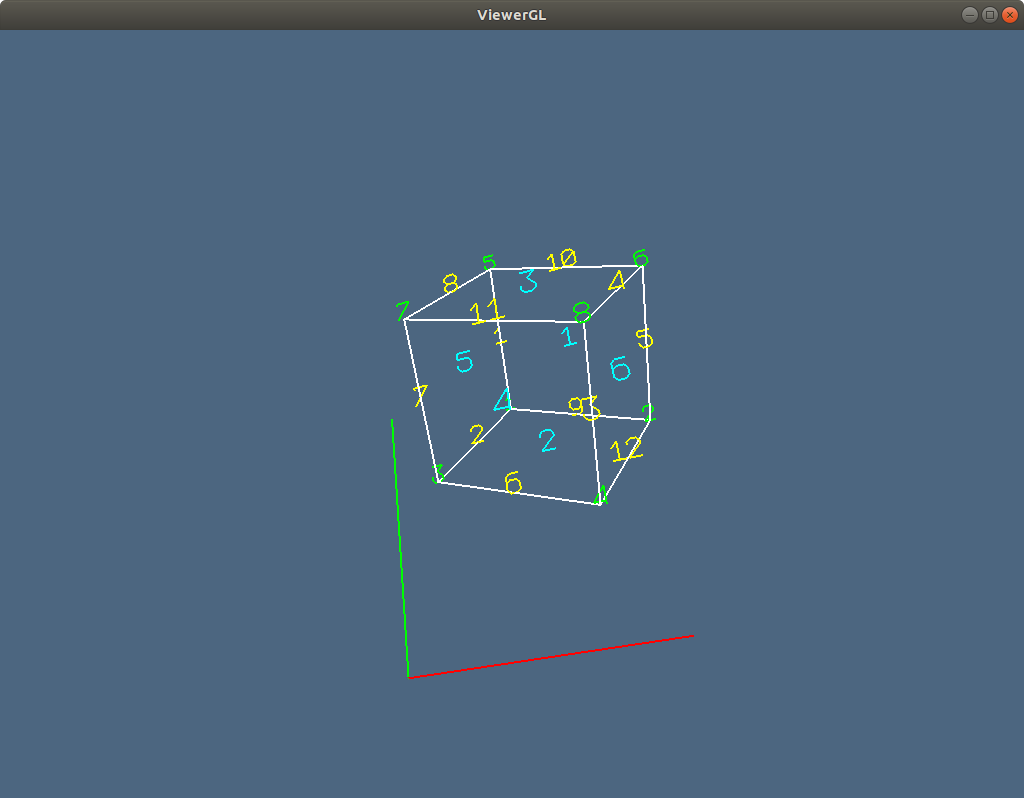

# Example 2: Two tetrahedrons

In [86]:
V, (VV,EV,FV,CV) = Lar.simplex(3, true)
tetra = V, EV,FV,CV
twotetra = Lar.Struct([ tetra, Lar.t(0.25,0.25,0.25), tetra ])
V,EV,FV,CV = Lar.struct2lar(twotetra)

#cop_EV = Lar.coboundary_0(EV::Lar.Cells);
#cop_EW = convert(Lar.ChainOp, cop_EV);
#cop_FE = Lar.coboundary_1(V, FV::Lar.Cells, EV::Lar.Cells);
W = convert(Lar.Points, V');

Delta_0 = SparseArrays.sparse([1, 3, 1, 4, 2, 3, 2, 4, 5, 7, 5, 8, 6, 7, 6, 8, 9, 11, 9, 12, 10, 11, 10, 12, 13, 15, 13, 16, 14, 15, 14, 16, 17, 19, 17, 20, 18, 19, 18, 20, 21, 23, 21, 24, 22, 23, 22, 24], [1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 12, 12, 13, 13, 14, 14, 15, 15, 16, 16, 17, 17, 18, 18, 19, 19, 20, 20, 21, 21, 22, 22, 23, 23, 24, 24], Int8[-1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1]);
Delta_1 = SparseArrays.sparse([1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5, 6, 6, 6, 6], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24], Int8[1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1]);

In [29]:
Delta_3 = SparseArrays.sparse([1, 3, 1], [1, 1, 3], Int8[-1, -1, 1]);
Delta_4 = SparseArrays.sparse([1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5, 6, 6, 6, 6], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24], Int8[1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1]);

In [30]:
sparseshow(Delta_0)

24×24 SparseMatrixCSC{Int8, Int64} with 48 stored entries:
 __|1___|2___|3___|4__|5___|6___|7___|18___  …  |19___|20__|21___|22___|23___|24__
  1|-1    1     ⋅   ⋅    ⋅    ⋅    ⋅    ⋅          ⋅    ⋅     ⋅     ⋅     ⋅    ⋅  
  2|  ⋅    ⋅  -1   1     ⋅    ⋅    ⋅    ⋅          ⋅    ⋅     ⋅     ⋅     ⋅    ⋅  
  3|-1     ⋅   1    ⋅    ⋅    ⋅    ⋅    ⋅          ⋅    ⋅     ⋅     ⋅     ⋅    ⋅  
  4|  ⋅  -1     ⋅  1     ⋅    ⋅    ⋅    ⋅          ⋅    ⋅     ⋅     ⋅     ⋅    ⋅  
  5|  ⋅    ⋅    ⋅   ⋅  -1    1     ⋅    ⋅    …     ⋅    ⋅     ⋅     ⋅     ⋅    ⋅  
  6|  ⋅    ⋅    ⋅   ⋅    ⋅    ⋅  -1     ⋅          ⋅    ⋅     ⋅     ⋅     ⋅    ⋅  
  7|  ⋅    ⋅    ⋅   ⋅  -1     ⋅    ⋅    ⋅          ⋅    ⋅     ⋅     ⋅     ⋅    ⋅  
  ⋮                      ⋮                   ⋱          ⋮                         
 18|  ⋅    ⋅    ⋅   ⋅    ⋅    ⋅    ⋅    ⋅          ⋅   1      ⋅     ⋅     ⋅    ⋅  
 19|  ⋅    ⋅    ⋅   ⋅    ⋅    ⋅    ⋅    ⋅         1     ⋅     ⋅     ⋅     ⋅    ⋅  
 20|  ⋅    ⋅    ⋅   ⋅    ⋅  

In [34]:
sparseshow(Delta_1)

6×24 SparseMatrixCSC{Int8, Int64} with 24 stored entries:
 _|1__|2___|3___|4__|5__|6___|7___|18___  …  |19___|20__|21__|22___|23___|24__
 1|1   -1   -1   1    ⋅    ⋅    ⋅    ⋅          ⋅    ⋅    ⋅     ⋅     ⋅    ⋅  
 2| ⋅    ⋅    ⋅   ⋅  1   -1   -1     ⋅          ⋅    ⋅    ⋅     ⋅     ⋅    ⋅  
 ⋮                    ⋮                   ⋱          ⋮                        
 5| ⋅    ⋅    ⋅   ⋅   ⋅    ⋅    ⋅  -1         -1    1     ⋅     ⋅     ⋅    ⋅  
 6| ⋅    ⋅    ⋅   ⋅   ⋅    ⋅    ⋅    ⋅          ⋅    ⋅   1    -1    -1    1   


# Normal Version

In [46]:
W

8×3 Matrix{Float64}:
 0.0   0.0   0.0
 1.0   0.0   0.0
 0.0   1.0   0.0
 0.0   0.0   1.0
 0.25  0.25  0.25
 1.25  0.25  0.25
 0.25  1.25  0.25
 0.25  0.25  1.25

In [87]:
@btime chaincongruence(W,Delta_0,Delta_1; epsilon=1e-4);

V = [0.0 0.0 0.0; 1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0; 0.25 0.25 0.25; 1.25 0.25 0.25; 0.25 1.25 0.25; 0.25 0.25 1.25]
Any[#undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef]
newcell=[1, 2] dim=1


Vector{Int64}[]

1-element Vector{Vector{Int64}}:
 [1, 2]

LoadError: UndefRefError: access to undefined reference

## Optimized Version

# Example 3: Random Shapes

In [94]:
V,EV,FV = Lar.randomcubes(5, .8)
	model3d = V,EV,FV
	VV = [[k] for k=1:size(V,2)]

	Sigma =  Lar.spaceindex((V,FV))


#L'errore è in questa funzione, non si riesce a capire cosa sia il keyword arguments dims
	V,EVs = Lar.biconnectedComponent((V,EV::Lar.Cells)) # 2-connected components (H & T)


	W,bases,coboundaries = Lar.chaincomplex(V,FV,EV)
	EV, FV, CV = bases
	copEV, copFE, copCF = coboundaries # OK

EV = Lar.cop2lar(copEV)
FE = [findnz(copFE[k,:])[1] for k=1:size(copFE,1)]
FV = [collect(Set(cat(EV[e] for e in FE[f]))) for f=1:length(FE)]
FV = convert(Lar.Cells, FV)
W = convert(Lar.Points, V')


LoadError: UndefKeywordError: keyword argument dims not assigned

# Two CubeGrids

In [84]:
V,(VV,EV,FV,CV) = Lar.cuboidGrid([5,5,5],true)
mybox = (V,CV,FV,EV)

twocubs = Lar.Struct([mybox, Lar.t(.3,.4,.5), Lar.r(pi/5,0,0), Lar.r(0,0,pi/12), mybox])

V,CV,FV,EV = Lar.struct2lar(twocubs)

cop_EV = Lar.coboundary_0(EV::Lar.Cells);
cop_EW = convert(Lar.ChainOp, cop_EV);
cop_FE = Lar.coboundary_1(V, FV::Lar.Cells, EV::Lar.Cells);
W = convert(Lar.Points, V');

V, copEV, copFE, copCF = Lar.Arrangement.spatial_arrangement( W, cop_EW, cop_FE)

W = convert(Lar.Points, V')

3×1192 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0      …  3.83553  3.83553  3.83553  3.83553
 0.0  0.0  1.0  1.0  0.0  1.0  1.0         4.17863  3.59084  3.00306  2.41527
 0.0  1.0  0.0  1.0  2.0  2.0  1.57897     5.71747  6.52649  7.3355   8.14452

In [85]:
Delta_0 = SparseArrays.sparse([1, 3, 1, 4, 2, 3, 2, 4, 5, 7, 5, 8, 6, 7, 6, 8, 9, 11, 9, 12, 10, 11, 10, 12, 13, 15, 13, 16, 14, 15, 14, 16, 17, 19, 17, 20, 18, 19, 18, 20, 21, 23, 21, 24, 22, 23, 22, 24], [1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 12, 12, 13, 13, 14, 14, 15, 15, 16, 16, 17, 17, 18, 18, 19, 19, 20, 20, 21, 21, 22, 22, 23, 23, 24, 24], Int8[-1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1]);
Delta_1 = SparseArrays.sparse([1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5, 6, 6, 6, 6], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24], Int8[1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1]);

In [62]:
chaincongruence(W,Delta_0,Delta_1; epsilon=1e-4);

V = [0.0 0.0 0.0; 1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0; 0.25 0.25 0.25; 1.25 0.25 0.25; 0.25 1.25 0.25; 0.25 0.25 1.25]
Any[#undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef]


LoadError: UndefRefError: access to undefined reference